<a href="https://colab.research.google.com/github/BrianKEverett/County-Line/blob/main/Dissertation_Everett.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Installing coding packages here, not dissertation code

In [544]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport

In [545]:
import time, os, sys, re
import zipfile, json, datetime, string
import numpy as np
from statistics import *

import matplotlib.pyplot as plt

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler
import plotly.express as px

import missingno as msno

from google.colab import files

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.max_columns = 50

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

plt.style.use('classic')

##Loading in datasets from GitHub
##Green text explains where data came from and how to find it

In [546]:
permits=pd.read_csv("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/Permits.csv")
# dataset can be found here: https://njdca.maps.arcgis.com/home/item.html?id=c754e8f800424bcbb6ad4e6e85b9f736 from NJ Dept of Community Affairs Website.
#this dataset was chosen mostly to assist with my dissertation proposal - I am seeking to explore the behaviors of planning boards in New Jersey, and one hypothesis I have is that planning board decisions are influenced by the effects of the County Line Balloting system, which is unique to 19 out of 21 counties in New Jersey. No other state in the US runs primary elections in this way.
#More on the County Line can be found here by Julia Sass Rubin: https://www.njpp.org/wp-content/uploads/2021/01/NJPP-Report-Does-the-County-Line-Matter-Update-wiht-Final-Vote-Counts.pdf

taxes=pd.read_csv ("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/mediantax.csv")
# dataset can be retireved via: https://njdca.maps.arcgis.com/apps/webappviewer/index.html?id=96ec274c50a34890b23263f101e4ad9b from NJ Department of Community Affairs
# Another hypothesis I have is that the public narrative put forth by planning board members when approving controversial permits, "this will increase rateables for the township, lowering your taxes", does not actually come to fruition
#This data set is helpful for exploring that narrative, and seeing if the opposite is occurring, i.e. more development actually yields higher property taxes

#health=pd.read_csv ("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/countyhealth.csv")
#dataset can be found here: https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation from County Health Rankings and Roadmaps, for 2022 to match same year of data for permits dataset
#With County Health Data, we can infer hypotheses about rates of development and the effect on well-being, liveability.

#Problem with health data set == only 22 observations for New Jersey, not a good sample.

municodes=pd.read_csv ("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/Municodes.csv")
#Data file of all NJ municiaplities, and counties, with the corresponding municipalitiy DCA code. This data file will be most helpful for matching and merging.

#crime=pd.read_csv ("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/CamdenCrime.csv") #not a good format for reading data!
#Dataset can be retireved here: https://www.nj.gov/njsp/ucr/uniform-crime-reports.shtml on the NJ Office of the Attorney General's website
#This crime data is important to consider when analyzing planning and zoning. Does any specific type of development correlate with increased crime? Can liveability theory be worked in here for whether or not communities have what they need to prevent crime?

jobs=pd.read_csv('https://raw.githubusercontent.com/BrianKEverett/County-Line/main/jobsdensity.csv')
#dataset can be built via the table selections on the NJ Community Affairs website - https://njdca.maps.arcgis.com/apps/webappviewer/index.html?id=96ec274c50a34890b23263f101e4ad9b
#Job density is a good variable to consider regarding new large dollar permits. Are some places growing more than others? Can this be attribute to the phenomenon of the County Line?

countysize=pd.read_csv('https://raw.githubusercontent.com/BrianKEverett/County-Line/main/NJCountySize.csv')
#dataset can be found via Wikipedia via 2020 census data - https://en.wikipedia.org/wiki/List_of_counties_in_New_Jersey

njtowns=pd.read_csv('https://raw.githubusercontent.com/BrianKEverett/County-Line/main/NJMunicipalities.csv')
#Dataset can be found at: https://en.wikipedia.org/wiki/List_of_municipalities_in_New_Jersey#:~:text=The%20largest%20municipality%20by%20population,most%20populous%20being%20South%20Carolina.

##Cleaning datasets by removing columns that are unnecessary, changing variable names to be text/code friendly while working, and changing string types as needed. Also manipulating font for better merging.

In [547]:
permits = permits.rename(columns={'DCA MUNI CODE': 'DCA'})
permits = permits.rename(columns={'MUNICIPALITY': 'Municipality'})
permits["Municipality"]= permits["Municipality"].str.title()
del permits['ID']
del permits['BLOCK NUMBER']
del permits['PAMS PIN']
del permits['USE GROUP']
del permits['YCOORD']
del permits['XCOORD']
del permits['MATCH TYPE']
del permits['LOT NUMBER']
del permits['DATE ISSUED']
del permits['TAX CODE']

del municodes['MUNICIPALITY_NAME_NJ-1040']
del municodes['MUNICIPALITY_CODE_DCA']
del municodes['MUNICIPALITY_NAME_DCA']
del municodes['MUNICIPALITY_CODE_GNIS']
del municodes['MUNICIPALITY_NAME_GNIS']
del municodes['MUNICIPALITY_CODE_FIPS']
municodes = municodes.rename(columns={'MUNICIPALITY_NAME_COMMON': 'Municipality'})
municodes = municodes.rename(columns={'MUNICIPALITY_CODE_NJ-1040': 'DCA'})
municodes = municodes.rename(columns={'COUNTY_NAME_COMMON': 'County'})
municodes['County'] = municodes['County'].str.replace(' County', '')
municodes = municodes.set_index('Municipality')

countysize['Largest City Population']=countysize['Largest City Population'].str.replace(',','')

del njtowns['Municipality Type']
del njtowns['Incorporated[5]']
del njtowns['Form of government']
njtowns = njtowns.set_index('Municipality')

##Isolating number of large permits per municipality

In [548]:
test = permits.groupby('Municipality').agg({'TYPE': 'count'})
test

TYPE
Municipality               
Aberdeen Twp              5
Absecon City              2
Alexandria Twp           11
Allamuchy Twp             4
Allendale Boro           10
...                     ...
Woodbury Heights Boro     1
Woodcliff Lake Boro      19
Woodland Park Boro        8
Woolwich Twp             25
Wyckoff Twp              30

[481 rows x 1 columns]

##Sorting newly created dataframe by Top 10 most permits per municipality

In [549]:
test = test.sort_values(by=['TYPE'], ascending=False)[:10]
print (test)

                          TYPE
Municipality                  
Jersey City                383
Newark City                252
Lakewood Twp               190
Dover Twp                  149
Ocean City                 136
Paramus Boro               132
Princeton (Consolidated)   129
Monroe Twp                 125
Edison Twp                 123
Long Beach Twp             113


##Pretty bargraph showing numbers of large permits per municipality, Top 10

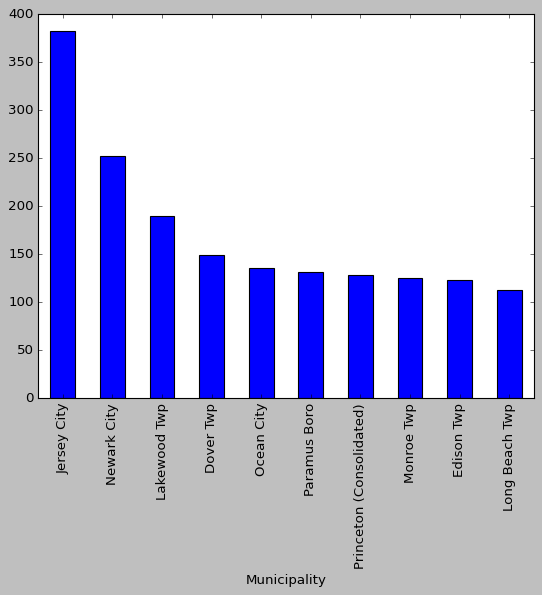

In [550]:
ax=test['TYPE'].plot(kind="bar")

##Merging the permits dataset with the municipal codes data set so that "County" can become a variable later on

In [551]:
codespermits = municodes.merge(permits, how='inner', on=['DCA'])
codespermits

County   DCA     Municipality  \
0     Atlantic   101     Absecon City   
1     Atlantic   101     Absecon City   
2     Atlantic   102    Atlantic City   
3     Atlantic   102    Atlantic City   
4     Atlantic   102    Atlantic City   
...        ...   ...              ...   
9778    Warren  2121  Washington Boro   
9779    Warren  2122   Washington Twp   
9780    Warren  2122   Washington Twp   
9781    Warren  2122   Washington Twp   
9782    Warren  2122   Washington Twp   

                                        Use Group Label TYPE WORK VALUE  
0                                            Mercantile  NEW    695,000  
1                                           Educational  ALT  4,000,000  
2     Clubs, Dance Halls, Casinos, Restaurants, Tave...  ALT  2,100,000  
3                      Residential (1 & 2 Family Homes)  ALT  2,100,000  
4       Churches, Libraries, Arcades, Comm. Halls, Gyms  ALT    337,400  
...                                                 ...  ...        ...  
9778                   Residential (1 & 2 Family Homes)  ALT  1,000,000  
9779                   Residential (1 & 2 Family Homes)  ALT    426,124  
9780                                        Educational  ALT    742,000  
9781                                           Business  ALT    276,000  
9782                                           Business  ALT    515,000  

[9783 rows x 6 columns]

##Sorting numbers of large permits by County to begin reevaluating County Line as part of research investigation

In [552]:
test2 = codespermits.groupby('County').agg({'TYPE': 'count'})
test2

TYPE
County          
Atlantic     406
Bergen      1294
Burlington   425
Camden       266
Cape May     530
Cumberland    73
Essex        731
Gloucester   227
Hudson       694
Hunterdon    102
Mercer       416
Middlesex    808
Monmouth     936
Morris       595
Ocean        991
Passaic      168
Salem         57
Somerset     338
Sussex       126
Union        540
Warren        60

##Pretty bar graph showing numbers of large permits per county.

##Do note! Salem has fewest, which is one of the two counties with County Line ballot design. Sussex is close, but ~double what Salem has. Sets up need to continue massaging data to do same type of graph once number of municipalities per county are taken into account, county area/density, jobs, etc., as seen at the bottom in notes.

            TYPE
County          
Bergen      1294
Ocean        991
Monmouth     936
Middlesex    808
Essex        731
Hudson       694
Morris       595
Union        540
Cape May     530
Burlington   425
Mercer       416
Atlantic     406
Somerset     338
Camden       266
Gloucester   227
Passaic      168
Sussex       126
Hunterdon    102
Cumberland    73
Warren        60
Salem         57


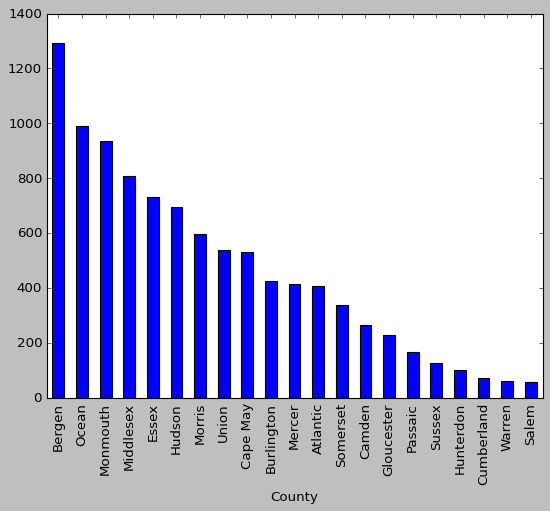

In [553]:
quiz1 = test2.sort_values(by=['TYPE'], ascending=False)
print (quiz1)
ax=quiz1['TYPE'].plot(kind="bar")

##Below, I tried to execute the same function to just count the number of municipalities per county, but something is weird with the municodes dataset.

##So, I tried the same code on the codespermits dataset and got the results below, which may actually be more important to the study because this shows the number of unique municipalities approving of at least one large dollar permit.

##Yes, there are 70 different municipalities in Bergen County, so, this suggests that every single town in Bergen County approved of at least one large dollar permit.

In [554]:
result = codespermits.groupby('County')['Municipality'].nunique().sort_values(ascending=False).reset_index(name='UniqueTowns')
result

County  UniqueTowns
0       Bergen           70
1     Monmouth           48
2       Morris           38
3   Burlington           35
4        Ocean           28
5       Camden           27
6    Middlesex           23
7        Essex           22
8    Hunterdon           21
9        Union           20
10    Atlantic           19
11      Sussex           19
12  Gloucester           19
13    Somerset           18
14      Warren           16
15    Cape May           16
16     Passaic           15
17      Hudson           12
18      Mercer           12
19       Salem           10
20  Cumberland            9

In [555]:
trick = result.sort_values(['UniqueTowns', 'County'], ascending=[False, False])
trick

County  UniqueTowns
0       Bergen           70
1     Monmouth           48
2       Morris           38
3   Burlington           35
4        Ocean           28
5       Camden           27
6    Middlesex           23
7        Essex           22
8    Hunterdon           21
9        Union           20
11      Sussex           19
12  Gloucester           19
10    Atlantic           19
13    Somerset           18
14      Warren           16
15    Cape May           16
16     Passaic           15
18      Mercer           12
17      Hudson           12
19       Salem           10
20  Cumberland            9

<Axes: title={'center': 'Unique Towns per County with at least 1 Large Permit'}, xlabel='County'>

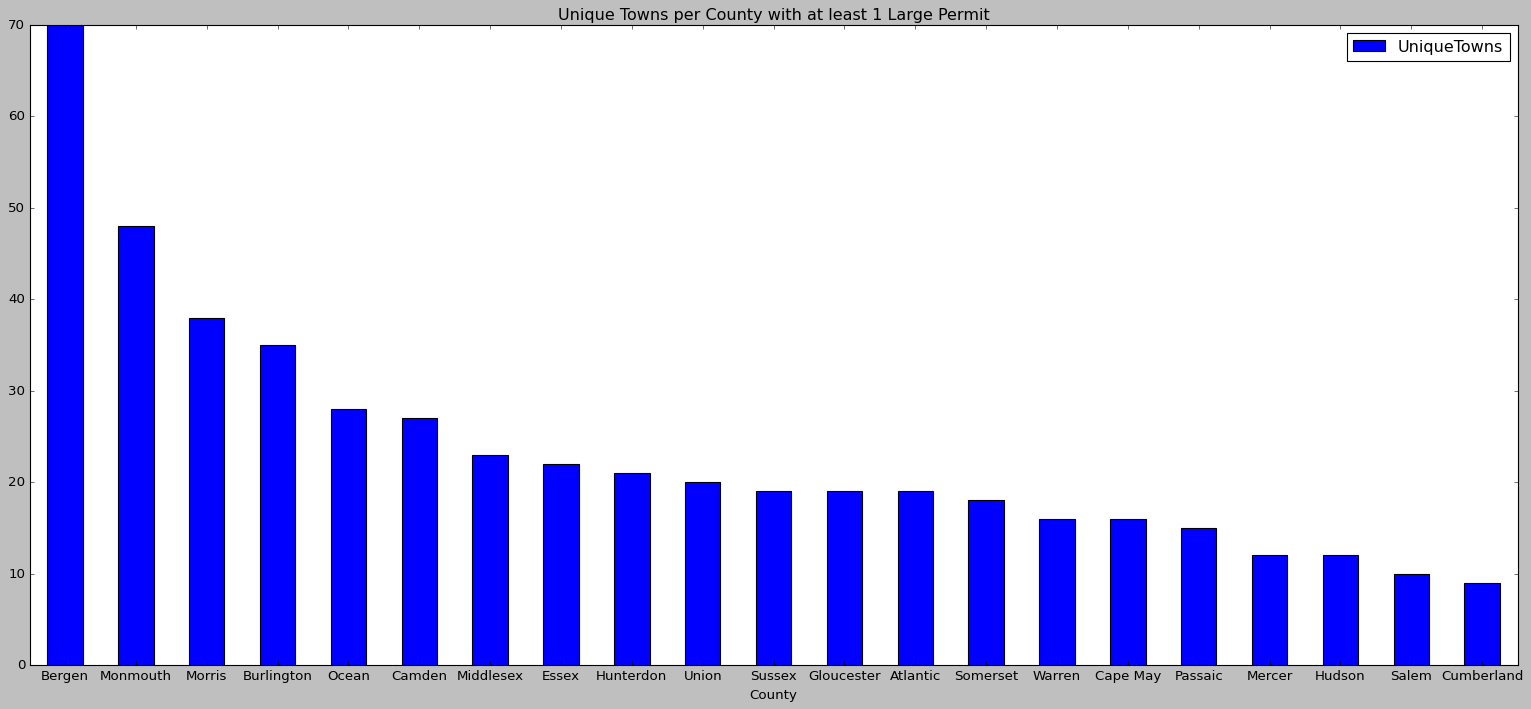

In [556]:
trick.plot.bar(x='County', y='UniqueTowns', title='Unique Towns per County with at least 1 Large Permit', rot=0, figsize=(24, 10))

In [557]:
jobs

Blk_Grp_Name            Municipality  \
0           Essex County Tract 218.02, Block Group 3  West Caldwell Township   
1           Essex County Tract 218.01, Block Group 2  West Caldwell Township   
2           Essex County Tract 218.02, Block Group 2  West Caldwell Township   
3     Gloucester County Tract 5016.08, Block Group 2         Monroe Township   
4     Gloucester County Tract 5002.03, Block Group 2  West Deptford Township   
...                                              ...                     ...   
1995       Monmouth County Tract 8096, Block Group 1       Marlboro Township   
1996       Monmouth County Tract 8096, Block Group 4       Marlboro Township   
1997    Monmouth County Tract 8097.01, Block Group 1       Marlboro Township   
1998          Bergen County Tract 101, Block Group 7          Dumont Borough   
1999          Bergen County Tract 102, Block Group 2          Dumont Borough   

          County  Jobs  JobsDensity  \
0          Essex  4376  4219.922635   
1          Essex    28    85.385941   
2          Essex  1939  1640.631286   
3     Gloucester   226   589.619454   
4     Gloucester   156   258.364616   
...          ...   ...          ...   
1995    Monmouth    90   107.930966   
1996    Monmouth   243   233.244240   
1997    Monmouth  2738   745.848682   
1998      Bergen    10    80.075270   
1999      Bergen   592  6652.557850   

                                            JobsVintage  
0     Longitudinal Employer-Household Dynamics Origi...  
1     Longitudinal Employer-Household Dynamics Origi...  
2     Longitudinal Employer-Household Dynamics Origi...  
3     Longitudinal Employer-Household Dynamics Origi...  
4     Longitudinal Employer-Household Dynamics Origi...  
...                                                 ...  
1995  Longitudinal Employer-Household Dynamics Origi...  
1996  Longitudinal Employer-Household Dynamics Origi...  
1997  Longitudinal Employer-Household Dynamics Origi...  
1998  Longitudinal Employer-Household Dynamics Origi...  
1999  Longitudinal Employer-Household Dynamics Origi...  

[2000 rows x 6 columns]

In [558]:
jobscount = jobs.groupby('County').agg({'Jobs': 'sum'})
jobscount

Jobs
County            
Atlantic       798
Bergen      145042
Burlington   39024
Camden       76817
Essex        38091
Gloucester   65311
Hudson      182982
Hunterdon    16306
Mercer      133215
Middlesex   226353
Monmouth     76920
Morris      115443
Ocean        79762
Passaic      59082
Salem          129
Somerset     54352
Sussex        3589
Union        63378
Warren        3919

In [559]:
tony = jobscount.sort_values(['Jobs', 'County'], ascending=[True, False])
print (tony)


              Jobs
County            
Salem          129
Atlantic       798
Sussex        3589
Warren        3919
Hunterdon    16306
Essex        38091
Burlington   39024
Somerset     54352
Passaic      59082
Union        63378
Gloucester   65311
Camden       76817
Monmouth     76920
Ocean        79762
Morris      115443
Mercer      133215
Bergen      145042
Hudson      182982
Middlesex   226353


##County Distribution of Jobs
Interesting results which can be relevant to dissertation study because the top three counties with the least jobs are 1. Salem, 2. Atlantic, 3. Sussex. Atlantic City may be an outlier due to poverty. Warren County also shows very low number of jobs in this view. This bar graph shows need to merge this dataset with population data as well as total area, as mentioned above.

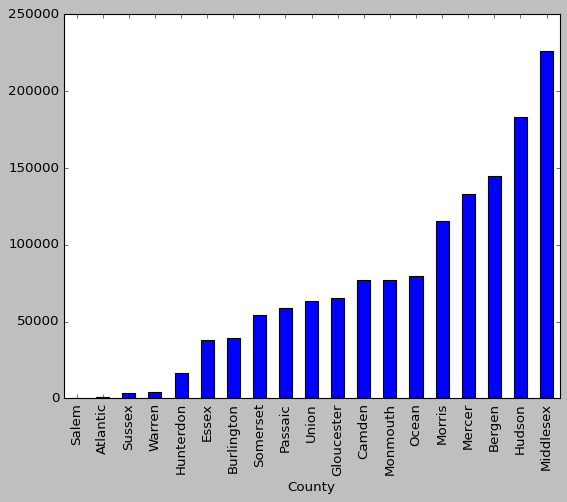

In [560]:
ax=tony['Jobs'].plot(kind="bar")

##County Size Dataset

In [561]:
countysize

County  FIPS Code  County Population  Area (miles squared)  \
0     Atlantic          1             275638                   561   
1       Bergen          3             952997                   234   
2   Burlington          5             466103                   805   
3       Camden          7             524907                   222   
4     Cape May          9              95634                   255   
5   Cumberland         11             151356                   489   
6        Essex         13             849477                   126   
7   Gloucester         15             306601                   325   
8       Hudson         17             703366                    47   
9    Hunterdon         19             129777                   430   
10      Mercer         21             380688                   226   
11   Middlesex         23             861418                   311   
12    Monmouth         25             644098                   472   
13      Morris         27             511151                   469   
14       Ocean         29             655735                   636   
15     Passaic         31             513936                   185   
16       Salem         33              65117                   338   
17    Somerset         35             346875                   305   
18      Sussex         37             146084                   521   
19       Union         39             569815                   103   
20      Warren         41             110926                   358   

             County Seat           Largest City Largest City Population  \
0           Mays Landing    Egg Harbor Township                   47842   
1             Hackensack             Hackensack                   46030   
2            Mount Holly       Evesham Township                   46826   
3                 Camden            Cherry Hill                   74553   
4   Cape May Court House         Lower Township                   22057   
5              Bridgeton               Vineland                   60780   
6                 Newark                 Newark                  311549   
7               Woodbury    Washington Township                   48677   
8            Jersey City            Jersey City                  292449   
9             Flemington       Raritan Township                   23447   
10               Trenton      Hamilton Township                   92297   
11         New Brunswick                 Edison                   92297   
12      Freehold Borough    Middletown Township                   67106   
13            Morristown  Parsippany-Troy Hills                   56162   
14            Toms River      Lakewood Township                  135158   
15              Paterson               Paterson                  159732   
16                 Salem    Pennsville Township                   12684   
17            Somerville      Franklin Township                   68364   
18                Newton        Vernon Township                   22358   
19             Elizabeth              Elizabeth                  137298   
20             Belvidere           Phillipsburg                   15249   

    Density (per mi2)  
0              491.33  
1             4072.64  
2              579.01  
3             2364.45  
4              375.04  
5              309.52  
6             6785.06  
7              943.39  
8            14965.23  
9              301.81  
10            1684.46  
11            2769.83  
12            1364.61  
13            1089.87  
14            1031.03  
15            2778.03  
16             192.65  
17            1137.30  
18             280.39  
19            5532.18  
20             309.85

In [562]:
countypop = countysize.groupby('County').agg({'County Population': 'sum'})
countypop

County Population
County                       
Atlantic               275638
Bergen                 952997
Burlington             466103
Camden                 524907
Cape May                95634
Cumberland             151356
Essex                  849477
Gloucester             306601
Hudson                 703366
Hunterdon              129777
Mercer                 380688
Middlesex              861418
Monmouth               644098
Morris                 511151
Ocean                  655735
Passaic                513936
Salem                   65117
Somerset               346875
Sussex                 146084
Union                  569815
Warren                 110926

            County Population
County                       
Salem                   65117
Cape May                95634
Warren                 110926
Hunterdon              129777
Sussex                 146084
Cumberland             151356
Atlantic               275638
Gloucester             306601
Somerset               346875
Mercer                 380688
Burlington             466103
Morris                 511151
Passaic                513936
Camden                 524907
Union                  569815
Monmouth               644098
Ocean                  655735
Hudson                 703366
Essex                  849477
Middlesex              861418
Bergen                 952997


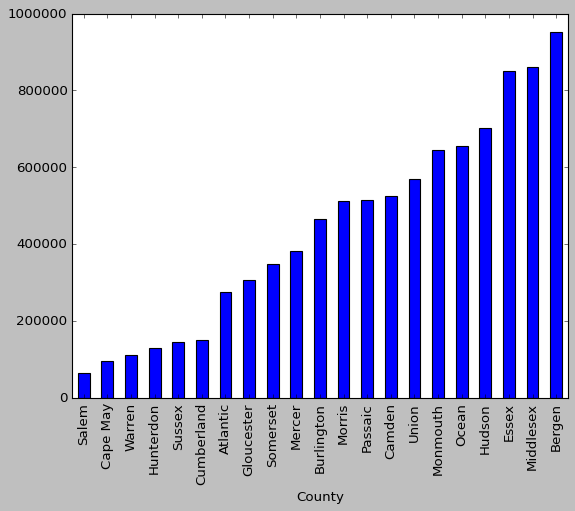

In [563]:
tony2 = countypop.sort_values(['County Population', 'County'], ascending=[True, False])
print (tony2)
ax=tony2['County Population'].plot(kind="bar")

In [564]:
countyarea = countysize.groupby('County').agg({'Area (miles squared)': 'sum'})
countyarea

Area (miles squared)
County                          
Atlantic                     561
Bergen                       234
Burlington                   805
Camden                       222
Cape May                     255
Cumberland                   489
Essex                        126
Gloucester                   325
Hudson                        47
Hunterdon                    430
Mercer                       226
Middlesex                    311
Monmouth                     472
Morris                       469
Ocean                        636
Passaic                      185
Salem                        338
Somerset                     305
Sussex                       521
Union                        103
Warren                       358

            Area (miles squared)
County                          
Hudson                        47
Union                        103
Essex                        126
Passaic                      185
Camden                       222
Mercer                       226
Bergen                       234
Cape May                     255
Somerset                     305
Middlesex                    311
Gloucester                   325
Salem                        338
Warren                       358
Hunterdon                    430
Morris                       469
Monmouth                     472
Cumberland                   489
Sussex                       521
Atlantic                     561
Ocean                        636
Burlington                   805


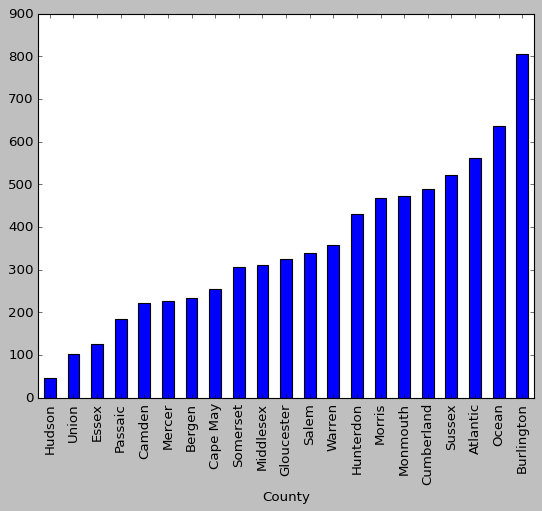

In [565]:
tony3 = countyarea.sort_values(['Area (miles squared)', 'County'], ascending=[True, False])
print (tony3)
ax=tony3['Area (miles squared)'].plot(kind="bar")

In [566]:
countydens = countysize.groupby('County').agg({'Density (per mi2)': 'sum'})
countydens

Density (per mi2)
County                       
Atlantic               491.33
Bergen                4072.64
Burlington             579.01
Camden                2364.45
Cape May               375.04
Cumberland             309.52
Essex                 6785.06
Gloucester             943.39
Hudson               14965.23
Hunterdon              301.81
Mercer                1684.46
Middlesex             2769.83
Monmouth              1364.61
Morris                1089.87
Ocean                 1031.03
Passaic               2778.03
Salem                  192.65
Somerset              1137.30
Sussex                 280.39
Union                 5532.18
Warren                 309.85

            Density (per mi2)
County                       
Salem                  192.65
Sussex                 280.39
Hunterdon              301.81
Cumberland             309.52
Warren                 309.85
Cape May               375.04
Atlantic               491.33
Burlington             579.01
Gloucester             943.39
Ocean                 1031.03
Morris                1089.87
Somerset              1137.30
Monmouth              1364.61
Mercer                1684.46
Camden                2364.45
Middlesex             2769.83
Passaic               2778.03
Bergen                4072.64
Union                 5532.18
Essex                 6785.06
Hudson               14965.23


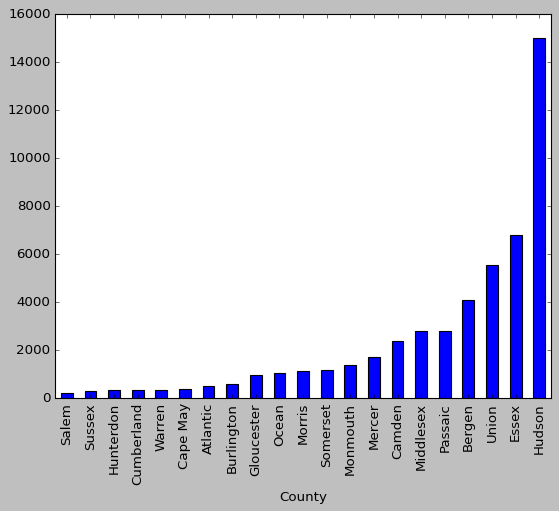

In [567]:
tony4 = countydens.sort_values(['Density (per mi2)', 'County'], ascending=[True, False])
print (tony4)
ax=tony4['Density (per mi2)'].plot(kind="bar")

In [568]:
stack = countysize.groupby('County').agg({'Density (per mi2)': 'sum', 'Area (miles squared)': 'sum'})
print (stack)

            Density (per mi2)  Area (miles squared)
County                                             
Atlantic               491.33                   561
Bergen                4072.64                   234
Burlington             579.01                   805
Camden                2364.45                   222
Cape May               375.04                   255
Cumberland             309.52                   489
Essex                 6785.06                   126
Gloucester             943.39                   325
Hudson               14965.23                    47
Hunterdon              301.81                   430
Mercer                1684.46                   226
Middlesex             2769.83                   311
Monmouth              1364.61                   472
Morris                1089.87                   469
Ocean                 1031.03                   636
Passaic               2778.03                   185
Salem                  192.65                   338
Somerset    

In [569]:
#ax = stack.plot.bar(stacked=True, color =['lightseagreen', 'tomato'], figsize=(10,8))
#^cool code, keeping it.

Text(0.5, 0, 'County')

Text(0, 0.5, 'Density and Area, mi^2')

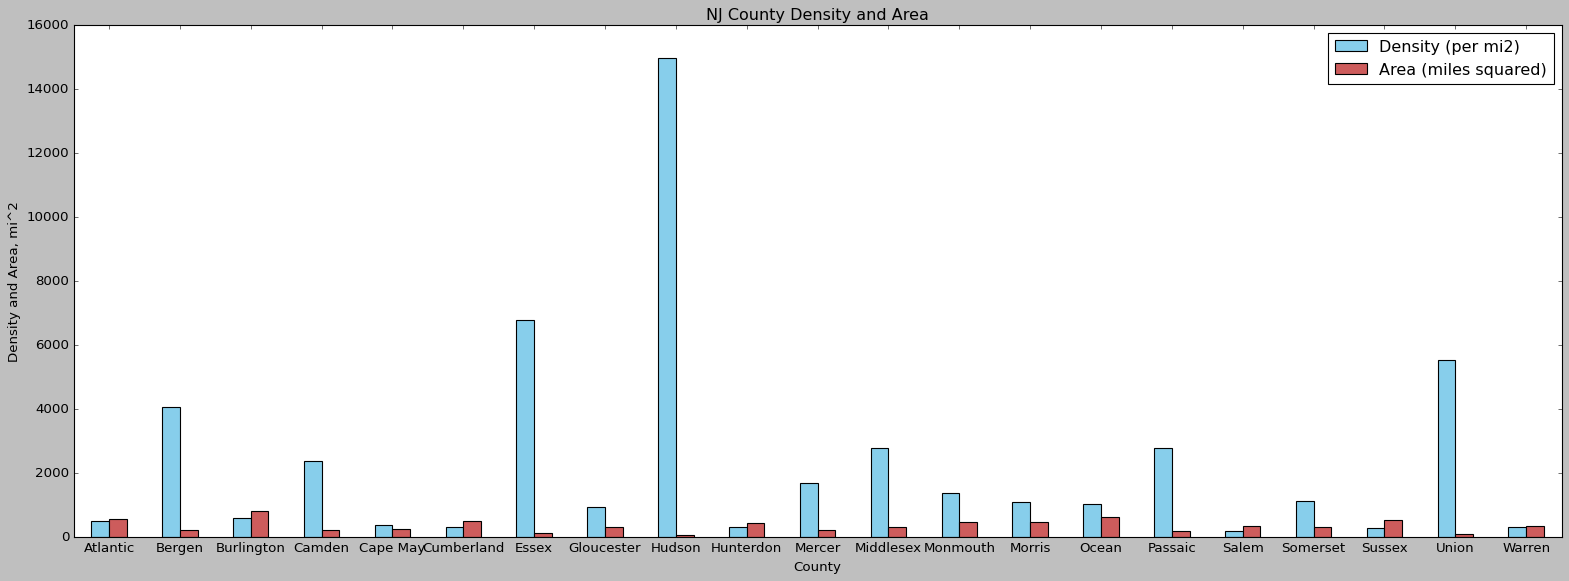

In [570]:
ax = stack.plot.bar(color=["SkyBlue","IndianRed"], rot=0, title="NJ County Density and Area", figsize=(24,8))
ax.set_xlabel("County")
ax.set_ylabel("Density and Area, mi^2")
plt.savefig('countydensity.pdf')

In [571]:
countymerge = quiz1.merge(countysize, how='inner', on=['County'])
countymerge

County  TYPE  FIPS Code  County Population  Area (miles squared)  \
0       Bergen  1294          3             952997                   234   
1        Ocean   991         29             655735                   636   
2     Monmouth   936         25             644098                   472   
3    Middlesex   808         23             861418                   311   
4        Essex   731         13             849477                   126   
5       Hudson   694         17             703366                    47   
6       Morris   595         27             511151                   469   
7        Union   540         39             569815                   103   
8     Cape May   530          9              95634                   255   
9   Burlington   425          5             466103                   805   
10      Mercer   416         21             380688                   226   
11    Atlantic   406          1             275638                   561   
12    Somerset   338         35             346875                   305   
13      Camden   266          7             524907                   222   
14  Gloucester   227         15             306601                   325   
15     Passaic   168         31             513936                   185   
16      Sussex   126         37             146084                   521   
17   Hunterdon   102         19             129777                   430   
18  Cumberland    73         11             151356                   489   
19      Warren    60         41             110926                   358   
20       Salem    57         33              65117                   338   

             County Seat           Largest City Largest City Population  \
0             Hackensack             Hackensack                   46030   
1             Toms River      Lakewood Township                  135158   
2       Freehold Borough    Middletown Township                   67106   
3          New Brunswick                 Edison                   92297   
4                 Newark                 Newark                  311549   
5            Jersey City            Jersey City                  292449   
6             Morristown  Parsippany-Troy Hills                   56162   
7              Elizabeth              Elizabeth                  137298   
8   Cape May Court House         Lower Township                   22057   
9            Mount Holly       Evesham Township                   46826   
10               Trenton      Hamilton Township                   92297   
11          Mays Landing    Egg Harbor Township                   47842   
12            Somerville      Franklin Township                   68364   
13                Camden            Cherry Hill                   74553   
14              Woodbury    Washington Township                   48677   
15              Paterson               Paterson                  159732   
16                Newton        Vernon Township                   22358   
17            Flemington       Raritan Township                   23447   
18             Bridgeton               Vineland                   60780   
19             Belvidere           Phillipsburg                   15249   
20                 Salem    Pennsville Township                   12684   

    Density (per mi2)  
0             4072.64  
1             1031.03  
2             1364.61  
3             2769.83  
4             6785.06  
5            14965.23  
6             1089.87  
7             5532.18  
8              375.04  
9              579.01  
10            1684.46  
11             491.33  
12            1137.30  
13            2364.45  
14             943.39  
15            2778.03  
16             280.39  
17             301.81  
18             309.52  
19             309.85  
20             192.65

In [572]:
sizepermits = countymerge.groupby('County').agg({'Density (per mi2)': 'sum', 'Area (miles squared)': 'sum', 'County Population': 'sum', 'TYPE': 'sum'})
sizepermits

Density (per mi2)  Area (miles squared)  County Population  TYPE
County                                                                      
Atlantic               491.33                   561             275638   406
Bergen                4072.64                   234             952997  1294
Burlington             579.01                   805             466103   425
Camden                2364.45                   222             524907   266
Cape May               375.04                   255              95634   530
Cumberland             309.52                   489             151356    73
Essex                 6785.06                   126             849477   731
Gloucester             943.39                   325             306601   227
Hudson               14965.23                    47             703366   694
Hunterdon              301.81                   430             129777   102
Mercer                1684.46                   226             380688   416
Middlesex             2769.83                   311             861418   808
Monmouth              1364.61                   472             644098   936
Morris                1089.87                   469             511151   595
Ocean                 1031.03                   636             655735   991
Passaic               2778.03                   185             513936   168
Salem                  192.65                   338              65117    57
Somerset              1137.30                   305             346875   338
Sussex                 280.39                   521             146084   126
Union                 5532.18                   103             569815   540
Warren                 309.85                   358             110926    60

In [573]:
corr = sizepermits[['Density (per mi2)','Area (miles squared)','County Population','TYPE']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-573-7aac216c61bb>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


##Interpreting the value of ρ
0.9 to 1 positive or negative indicates a very strong correlation.

0.7 to 0.9 positive or negative indicates a strong correlation.

0.5 to 0.7 positive or negative indicates a moderate correlation.

0.3 to 0.5 positive or negative indicates a weak correlation.

0 to 0.3 positive or negative indicates a negligible correlation.

Source: https://medium.com/brdata/correlation-straight-to-the-point-e692ab601f4c

##Notes on correlation graph above

Of course, definitely want to try again once jobs are added. May even be able to add crime - why not? More variable probably the better in this case.

Based on above results, number of permits (TYPE) seems highly correlated with county population, as well as marginally correlated with Density.

In [574]:
sizepermits["County Line"] = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
sizepermits

Density (per mi2)  Area (miles squared)  County Population  TYPE  \
County                                                                         
Atlantic               491.33                   561             275638   406   
Bergen                4072.64                   234             952997  1294   
Burlington             579.01                   805             466103   425   
Camden                2364.45                   222             524907   266   
Cape May               375.04                   255              95634   530   
Cumberland             309.52                   489             151356    73   
Essex                 6785.06                   126             849477   731   
Gloucester             943.39                   325             306601   227   
Hudson               14965.23                    47             703366   694   
Hunterdon              301.81                   430             129777   102   
Mercer                1684.46                   226             380688   416   
Middlesex             2769.83                   311             861418   808   
Monmouth              1364.61                   472             644098   936   
Morris                1089.87                   469             511151   595   
Ocean                 1031.03                   636             655735   991   
Passaic               2778.03                   185             513936   168   
Salem                  192.65                   338              65117    57   
Somerset              1137.30                   305             346875   338   
Sussex                 280.39                   521             146084   126   
Union                 5532.18                   103             569815   540   
Warren                 309.85                   358             110926    60   

            County Line  
County                   
Atlantic              1  
Bergen                1  
Burlington            1  
Camden                1  
Cape May              1  
Cumberland            1  
Essex                 1  
Gloucester            1  
Hudson                1  
Hunterdon             1  
Mercer                1  
Middlesex             1  
Monmouth              1  
Morris                1  
Ocean                 1  
Passaic               1  
Salem                 0  
Somerset              1  
Sussex                0  
Union                 1  
Warren                1

In [575]:
corr = sizepermits[['Density (per mi2)','Area (miles squared)','County Population','TYPE', 'County Line']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-575-9ec0ed23aeaf>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


In [576]:
jobs2 = jobs.groupby('County').agg({'Jobs': 'sum'})
print (jobs2)

              Jobs
County            
Atlantic       798
Bergen      145042
Burlington   39024
Camden       76817
Essex        38091
Gloucester   65311
Hudson      182982
Hunterdon    16306
Mercer      133215
Middlesex   226353
Monmouth     76920
Morris      115443
Ocean        79762
Passaic      59082
Salem          129
Somerset     54352
Sussex        3589
Union        63378
Warren        3919


In [577]:
countyline = jobs2.merge(sizepermits, how='inner', on=['County'])
countyline

Jobs  Density (per mi2)  Area (miles squared)  \
County                                                        
Atlantic       798             491.33                   561   
Bergen      145042            4072.64                   234   
Burlington   39024             579.01                   805   
Camden       76817            2364.45                   222   
Essex        38091            6785.06                   126   
Gloucester   65311             943.39                   325   
Hudson      182982           14965.23                    47   
Hunterdon    16306             301.81                   430   
Mercer      133215            1684.46                   226   
Middlesex   226353            2769.83                   311   
Monmouth     76920            1364.61                   472   
Morris      115443            1089.87                   469   
Ocean        79762            1031.03                   636   
Passaic      59082            2778.03                   185   
Salem          129             192.65                   338   
Somerset     54352            1137.30                   305   
Sussex        3589             280.39                   521   
Union        63378            5532.18                   103   
Warren        3919             309.85                   358   

            County Population  TYPE  County Line  
County                                            
Atlantic               275638   406            1  
Bergen                 952997  1294            1  
Burlington             466103   425            1  
Camden                 524907   266            1  
Essex                  849477   731            1  
Gloucester             306601   227            1  
Hudson                 703366   694            1  
Hunterdon              129777   102            1  
Mercer                 380688   416            1  
Middlesex              861418   808            1  
Monmouth               644098   936            1  
Morris                 511151   595            1  
Ocean                  655735   991            1  
Passaic                513936   168            1  
Salem                   65117    57            0  
Somerset               346875   338            1  
Sussex                 146084   126            0  
Union                  569815   540            1  
Warren                 110926    60            1

In [578]:
corr = countyline[['Density (per mi2)','Area (miles squared)','County Population', 'Jobs','TYPE', 'County Line']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-578-5e4f312f4abc>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


In [579]:
corr = countyline[['Density (per mi2)','Area (miles squared)', 'Jobs','TYPE', 'County Line', 'County Population']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-579-44291e930769>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


#Quick Takeaway Here:
County Line is most correlated with County Population at .49, and County Population is most correlated with permits (TYPE). So although the county line has a weak correlation with number of permits (TYPE) at .39, its strongest correlation (a moderate one) is with County Population at .49, of which, County Population is most correlated with number of permits (TYPE) at .88, a very strong correlation.

#SEPARATION BAR -
##Repeat same approach but at municipal level rather than county level for sample size purposes

In [580]:
permits = permits.rename(columns={'TYPE': 'Permits'})
permits = permits.set_index('Municipality')

del njtowns['Population density']
del njtowns['Land Area (km^2)']
del njtowns['Pop. Change']

del permits['Use Group Label']
del permits['WORK VALUE']

jobs = jobs.set_index('Municipality')
del jobs['JobsVintage']
del jobs['Blk_Grp_Name']
del jobs['JobsDensity']

taxes = taxes.set_index('Municipality')
del taxes['Tract_Name']
del taxes['Data_Vintage']
del taxes[' ']


njtowns
permits
jobs
taxes
municodes

County  Population (2020)  Population (2010)  \
Municipality                                                            
Aberdeen Township      Monmouth              19329              18157   
Absecon                Atlantic               9137               8411   
Alexandria Township   Hunterdon               4809               4938   
Allamuchy Township       Warren               5335               4323   
Allendale                Bergen               6848               6505   
...                         ...                ...                ...   
Woodlynne                Camden               2902               2978   
Woodstown                 Salem               3678               3505   
Woolwich Township    Gloucester              12577              10200   
Wrightstown          Burlington                720                802   
Wyckoff                  Bergen              16585              16635   

                     Land area (mi^2)  
Municipality                           
Aberdeen Township               5.444  
Absecon                         5.468  
Alexandria Township            27.534  
Allamuchy Township             19.992  
Allendale                       3.097  
...                               ...  
Woodlynne                       0.218  
Woodstown                       1.575  
Woolwich Township              21.072  
Wrightstown                     1.850  
Wyckoff                         6.591  

[564 rows x 4 columns]

DCA Permits
Municipality                 
Absecon City      101     NEW
Absecon City      101     ALT
Atlantic City     102     ALT
Atlantic City     102     ALT
Atlantic City     102     ALT
...               ...     ...
Washington Boro  2121     ALT
Washington Twp   2122     ALT
Washington Twp   2122     ALT
Washington Twp   2122     ALT
Washington Twp   2122     ALT

[9783 rows x 2 columns]

County  Jobs
Municipality                            
West Caldwell Township       Essex  4376
West Caldwell Township       Essex    28
West Caldwell Township       Essex  1939
Monroe Township         Gloucester   226
West Deptford Township  Gloucester   156
...                            ...   ...
Marlboro Township         Monmouth    90
Marlboro Township         Monmouth   243
Marlboro Township         Monmouth  2738
Dumont Borough              Bergen    10
Dumont Borough              Bergen   592

[2000 rows x 2 columns]

County  Median_RE_Taxes
Municipality                                    
Bridgewater Township   Somerset          10000.0
Bernards Township      Somerset          10000.0
Franklin Township      Somerset           9604.0
Woodbridge Township   Middlesex           9041.0
Woodbridge Township   Middlesex           7496.0
...                         ...              ...
Franklin Township      Somerset          10000.0
Franklin Township      Somerset           6600.0
Franklin Township      Somerset          10000.0
Bernards Township      Somerset          10000.0
Bernards Township      Somerset          10000.0

[1646 rows x 2 columns]

County   DCA
Municipality                        
Absecon               Atlantic   101
Atlantic City         Atlantic   102
Brigantine            Atlantic   103
Buena Borough         Atlantic   104
Buena Vista Township  Atlantic   105
...                        ...   ...
Phillipsburg            Warren  2119
Pohatcong Township      Warren  2120
Washington Borough      Warren  2121
Washington Township     Warren  2122
White Township          Warren  2123

[564 rows x 2 columns]

In [581]:
permits = municodes.merge(permits, how='inner', on=['Municipality'])
permits = permits.rename(columns={'DCA_x': 'DCA'})
del permits['DCA_y']
permits

County   DCA Permits
Municipality                               
Atlantic City        Atlantic   102     ALT
Atlantic City        Atlantic   102     ALT
Atlantic City        Atlantic   102     ALT
Atlantic City        Atlantic   102     ALT
Atlantic City        Atlantic   102     ALT
...                       ...   ...     ...
Colts Neck Township  Monmouth  1310     NEW
Colts Neck Township  Monmouth  1310     ALT
Colts Neck Township  Monmouth  1310     NEW
Colts Neck Township  Monmouth  1310     ALT
Loch Arbour Village  Monmouth  1326     ALT

[861 rows x 3 columns]

##Consider different types of graphs other than bar graphs. histogram or even scatter plot might be useful. Consider reviewing scatter plot from happiness study.

##Review top of workbook and consider deleting first 3 things. Just tests, not of use to study.

##Do not forget to later do a merge with the jobs dataset too. That one should be last because it is at municipal level but can be grouped or agg by county totals. Must be careful with that merge in order to make sure data is not lost.

##Hypothesis:
Once jobs dataset is added, we can begin doing stats testing to see if variations exists or if trends can be identified. "When holding all things constant, counties with higher density correlated unequally with number of high dollar permits, perhaps at outlier level extremes".

##Also, do not forget to create dataset which lists county line counties and non-county line counties. 1's and 0's probably.

##Notes for future work:
Can try to do a stacked graph with the countysize dataset with various variable/combinations

maybe try to merge countysize dataset with codespermits to produce new graphs

should overall try to take these graphs and begin writing in word doc and also see if codespermits v. desnity and v. countypop shows anything interesting.

also, try to get a downloadable file of the $250K dataset for funzies.

##Notes for Data Information
Spoke with Joseph Naylor on the phone from NJ DCA

Learned that these permits come through a process governed by Division of Codes and Standards - these are building permits.

I may be confused about roles between Planning Boards and Zoning Boards of Adjustment.

Mr. Naylor did send me a link to the 2019 dataset which produced data at the level of $250K and higher.

He suggested that the new dataset (above) moved to be $499K and higher because they felt like the lower threshold did not do enough filtering, and was capturing too much. Still cannot download the 2019 dataset so I need to reach out once more.

The 2019 dataset will be great to have for comparision and longitude, but also might further confirm observed trends with many more observations.